In [24]:
import numpy as np
import xarray as xr
import scipy

import sys
import os

import pickle
import tqdm

import json
from shapely.geometry import shape, Point
import matplotlib.pyplot as plt
import cartopy as cart
import scipy

In [2]:
Atlantic = {
      "type": "Polygon",
      "coordinates": [
          [[  -74.1361810961009, 48.373792170946786],
          [  -67.33533744590342, 47.65387298440368],
          [  -65.55986632011246, 45.9792437876242],
          [  -72.02719847958402, 44.53104524798408],
          [  -71.16038684142649, 41.86644013062025],
          [  -76.86924090652485, 40.74587733806143],
          [  -77.86752937901312, 35.71245307084121],
          [  -82.36371712191027, 31.645160248279296],
          [  -97.24514351293215, 29.94573639618241],
          [  -99.85186776358252, 24.233602091358847],
          [  -95.92885990389013, 18.127482590027228],
          [  -89.3600396690473, 15.572266600672307],
          [  -84.28781886784049, 14.773744110986144],
          [  -83.8388055635338, 10.191292463555811],
          [  -81.31510031795777, 8.235007092105846],
          [  -79.25416134594884, 9.35523938640442],
          [  -78.14328505258835, 8.761611821374913],
          [  -77.73830373563413, 7.875396003538171],
          [  -75.19484080994795, 7.552831906919053],
          [  -36.53076821160431, -8.925436070859305],
          [  -72.02020616528678, -46.68931246995514],
          [  -67.97290461351264, -55],
          [  20, -55],
          [  20, -14],
          [  18.97436692646147, -11.917217920873952],
          [  9.127087807805538, 7.59492557772019],
          [  -8.91416344160237, 6.93366511454127],
          [  -15.067201051501996, 15.752353747499669],
          [  -11.178000956607491, 25.063512467505575],
          [  -5.7894560628897125, 36.836870844581625],
          [  12.93209197140203, 52.900934983799374],
          [  14.448383948559325, 65],
          # [  -61.38021334416041, 60],
          # [  -66.64123170764944, 60],
          [  -65.21821112783054, 65],
          [  -74.1361810961009, 48.373792170946786]
          ]
        ],
        "type": "Polygon"}

In [3]:
atl_shape = shape(Atlantic)

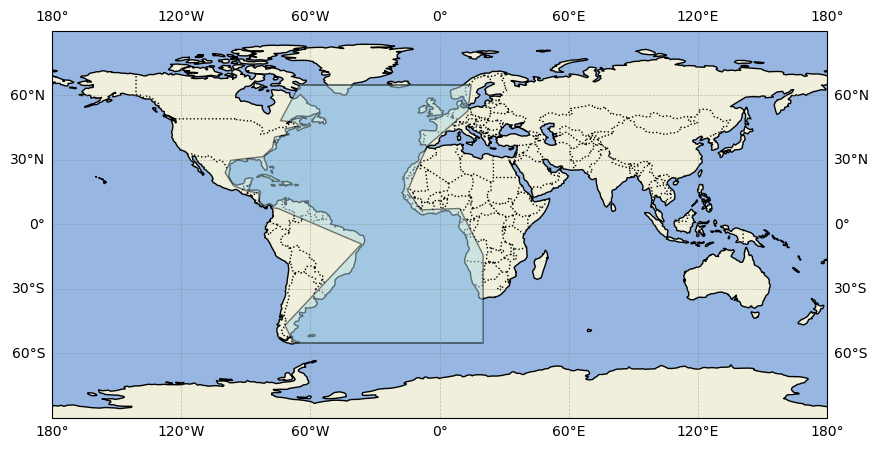

In [4]:
fig = plt.figure(figsize=(10, 8))
ax = plt.axes(projection=cart.crs.PlateCarree())
ax.add_feature(cart.feature.LAND)
ax.add_feature(cart.feature.OCEAN)
ax.add_feature(cart.feature.COASTLINE)
ax.add_feature(cart.feature.BORDERS, linestyle=':')
ax.gridlines(draw_labels=True, linestyle='--', color='gray', alpha=0.5, linewidth=0.5)
ax.add_geometries([atl_shape], cart.crs.PlateCarree(), facecolor='lightblue', edgecolor='black', alpha=0.5)

plt.show()

In [35]:
class regularParticleGrid:
    def __init__(self, res):
        self.res = res
        self.dlon = self.dlat = 1/ self.res

        self.gen_lon = np.arange(-100, 20 + self.dlon, self.dlon)
        self.gen_lat = np.arange(-55, 65 + self.dlat, self.dlat)

        self.gen_lon_grid, self.gen_lat_grid = np.meshgrid(self.gen_lon, self.gen_lat)

        self.lons = self.gen_lon_grid.flatten()
        self.lats = self.gen_lat_grid.flatten()
    
    def filter_polygon(self, polygon):
        filter_keep_polygon = np.ones_like(self.lons, dtype=bool)

        for idx, lon in tqdm.tqdm(enumerate(self.lons)):
            if not polygon.contains(Point(lon, self.lats[idx])):
                filter_keep_polygon[idx] = False

        self.lons = self.lons[filter_keep_polygon]
        self.lats = self.lats[filter_keep_polygon]

    @property
    def lonlat(self):
        return np.column_stack((self.lons, self.lats))

    @property
    def size(self):
        """
        Returns the number of particles.
        """
        return self.lons.size

    def mask(self, mask_lons, mask_lats, mask):
        """
        Mask the particles using a given mask, for instance to get rid of particles on land.

        Parameters
        ----------
        mask_lons : xarray.DataArray
            The longitudes of the mask.
        mask_lats : xarray.DataArray
            The latitudes of the mask.
        mask : xarray.DataArray
            The mask itself.
        """

        if type(mask_lons) == xr.DataArray:
            mask_lons = mask_lons.values
        if type(mask_lats) == xr.DataArray:
            mask_lats = mask_lats.values
        if type(mask) == xr.DataArray:
            mask = mask.values

        lonlatMask = scipy.interpolate.griddata(np.column_stack((mask_lons.flatten(), mask_lats.flatten())), 
                                                     mask.flatten(), 
                                                     self.lonlat, 
                                                     method='nearest')

        
        self.lons = self.lons[lonlatMask]
        self.lats = self.lats[lonlatMask]

    @property
    def lonlat_dict(self):
        return {"lon": self.lons, "lat": self.lats, "dlon": self.dlon}


In [29]:
surface_4th = regularParticleGrid(4)
surface_4th.filter_polygon(atl_shape)

231361it [00:05, 40198.46it/s]


In [30]:
mask = xr.open_dataset("/nethome/4302001/data/input_data/MOi/domain_ORCA0083-N006/PSY4V3R1_mask.nc").isel(t=0).isel(x=slice(2250, 3700), y=slice(500, 2800))

In [20]:
full_water =(mask.tmask.isel(z=0).astype(bool) * mask.umask.isel(z=0).astype(bool) * mask.vmask.isel(z=0).astype(bool) * mask.fmask.isel(z=0).astype(bool))

In [25]:
surface_4th.mask(mask.nav_lon, mask.nav_lat, full_water)

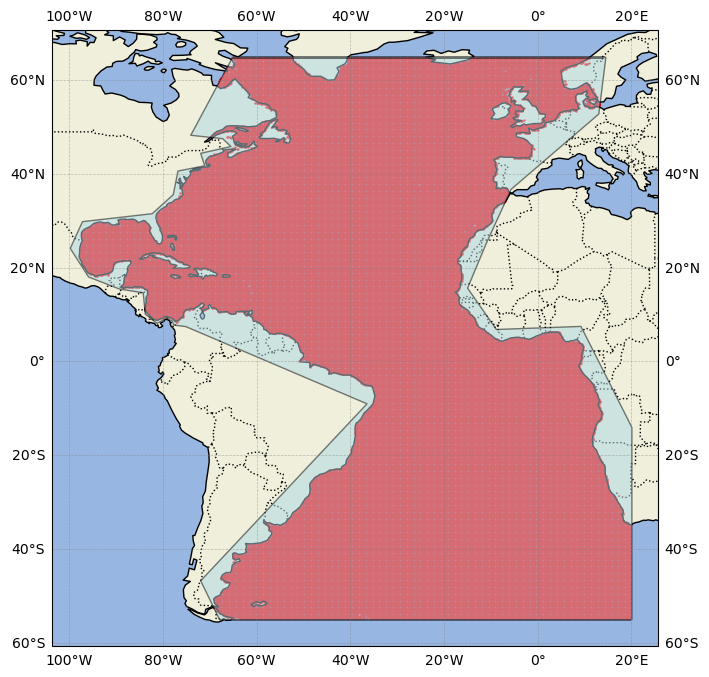

In [27]:
fig = plt.figure(figsize=(10, 8))
ax = plt.axes(projection=cart.crs.PlateCarree())
ax.add_feature(cart.feature.LAND)
ax.add_feature(cart.feature.OCEAN)
ax.add_feature(cart.feature.COASTLINE)
ax.add_feature(cart.feature.BORDERS, linestyle=':')
ax.gridlines(draw_labels=True, linestyle='--', color='gray', alpha=0.5, linewidth=0.5)

ax.scatter(surface_4th.lons, surface_4th.lats, transform=cart.crs.PlateCarree(), s=0.5, c='r')
ax.add_geometries([atl_shape], cart.crs.PlateCarree(), facecolor='lightblue', edgecolor='black', alpha=0.5)

plt.show()

In [32]:
with open(f"Atlantic_regular_res4_surface_lonlat-dict.pkl", "wb") as f:
    pickle.dump(surface_4th.lonlat_dict, f)

In [36]:
surface_12th = regularParticleGrid(12)
surface_12th.filter_polygon(atl_shape)

0it [00:00, ?it/s]

686307it [00:18, 37690.76it/s]

In [37]:
surface_12th.mask(mask.nav_lon, mask.nav_lat, full_water)

In [38]:
with open(f"Atlantic_regular_res12_surface_lonlat-dict.pkl", "wb") as f:
    pickle.dump(surface_12th.lonlat_dict, f)